In [27]:
# 
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
# Импорт библиотеки seaborn для построения парных графиков
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
print(tf.__version__)

2.12.0


In [28]:
# Загружаем данные из репозитория в локальную папку компьютера.
dataset_path = keras.utils.get_file("/home/lawrenceub/VSCodeProjects/PythonLaba7.3/auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/lawrenceub/VSCodeProjects/PythonLaba7.3/auto-mpg.data'

In [29]:
column_names = ['Расход топлива','Кол-во цилиндров','Объем двигателя','Л.с.','Вес',
'Разгон до 100 км/ч', 'Год выпуска', 'Страна выпуска']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
#  Вывод последних 5 строк
dataset.tail()

,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,Страна выпуска
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [30]:
# подготовка данных 
dataset.isna().sum()

Расход топлива        0
Кол-во цилиндров      0
Объем двигателя       0
Л.с.                  6
Вес                   0
Разгон до 100 км/ч    0
Год выпуска           0
Страна выпуска        0
dtype: int64

In [31]:
# нулевые удалили
dataset = dataset.dropna()

# Извлечение столбца с удалением его из набора
origin = dataset.pop('Страна выпуска')

# Добавление новых столбцов
dataset['США'] = (origin == 1)*1.0
dataset['Европа'] = (origin == 2)*1.0
dataset['Япония'] = (origin == 3)*1.0
#  Вывод последних 5 строк
dataset.tail()

,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,США,Европа,Япония
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


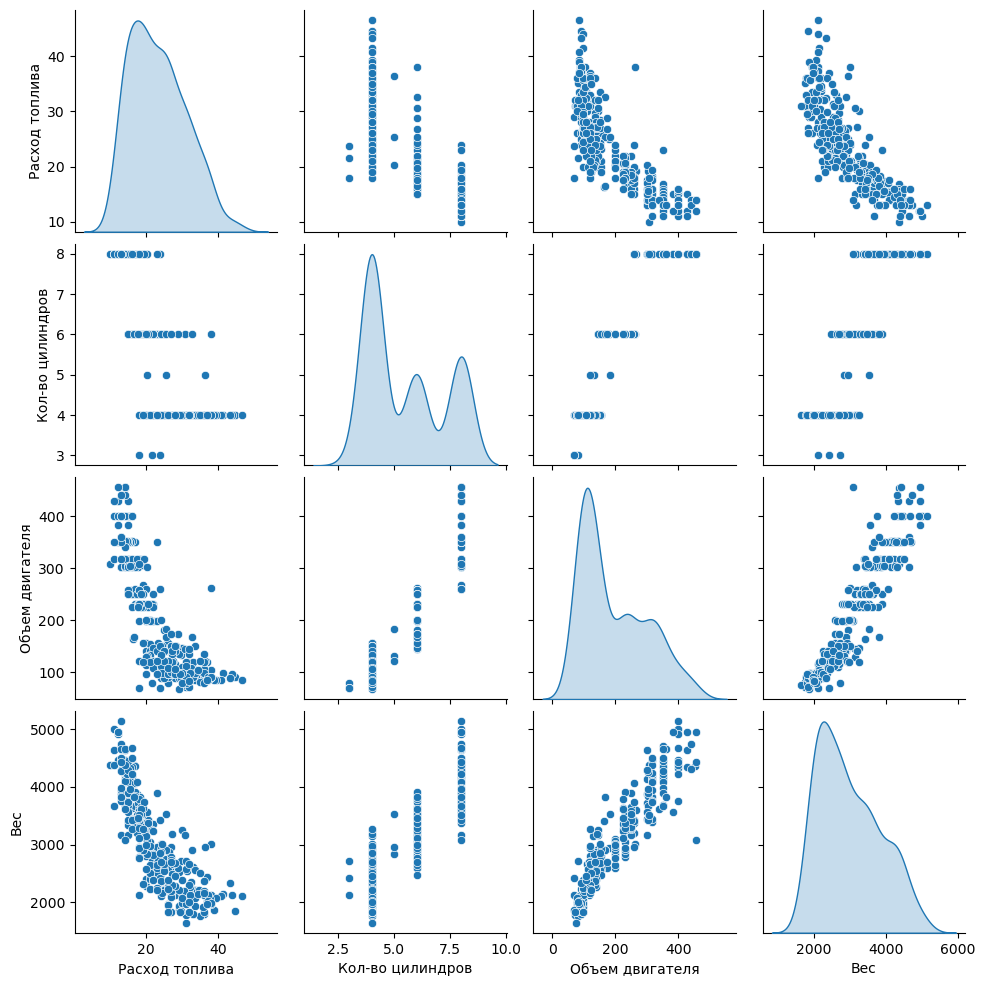

In [32]:
# Разделение данных на тернировочные и проверочные
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["Расход топлива", "Кол-во цилиндров", "Объем двигателя", "Вес"]], diag_kind="kde")

In [33]:
#Вывод общей статистики:
train_stats = train_dataset.describe()
train_stats.pop("Расход топлива")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Кол-во цилиндров,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Объем двигателя,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Л.с.,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Вес,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Разгон до 100 км/ч,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Год выпуска,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
США,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Европа,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Япония,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [34]:
#Необходимо отделить целевые значения от характеристик и использовать эти значения для обучения модели регрессии
# Извлечение целевого столбца с удалением из набора

train_labels = train_dataset.pop('Расход топлива')
test_labels = test_dataset.pop('Расход топлива')

# Функция нормализации
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# Нормализация данных
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# построение модели

from keras import models

def build_model():
  model = keras.Sequential([
  layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(1)
  ])

  #optimizer = tf.train.RMSPropOptimizer(0.001)
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# mse - mean_squared_error (средняя квадратическая ошибка)
# mae - mean_absolute_error (средняя абсолютная ошибка)
  model.compile(loss='mse', optimizer = opt, metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                640       
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [35]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 320ms/step


array([[ 0.07901768],
       [-0.01904935],
       [-0.05149835],
       [ 0.05865716],
       [ 0.09080871],
       [-0.08798736],
       [ 0.11403485],
       [ 0.04701111],
       [-0.03853918],
       [ 0.04308179]], dtype=float32)

In [36]:
# Обучение модели
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs):
    # Перевод строки после 100 эпох
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
# validation_split = 0.2 - 20% данных отводится на проверку
history = model.fit(
 normed_train_data, train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose=0,
 callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [37]:
# Выполним визуализацию процесса обучения при помощи статистики из объекта history:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#  Вывод последних 5 строк
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.840481,1.008692,1.840481,10.941183,2.476368,10.941183,995
996,1.852891,0.941170,1.852891,12.903111,2.611755,12.903111,996
997,1.777778,0.968105,1.777778,11.745447,2.706509,11.745448,997
998,1.128496,0.705410,1.128496,11.070793,2.511092,11.070793,998
999,1.802907,0.957130,1.802907,15.076122,2.731964,15.076122,999


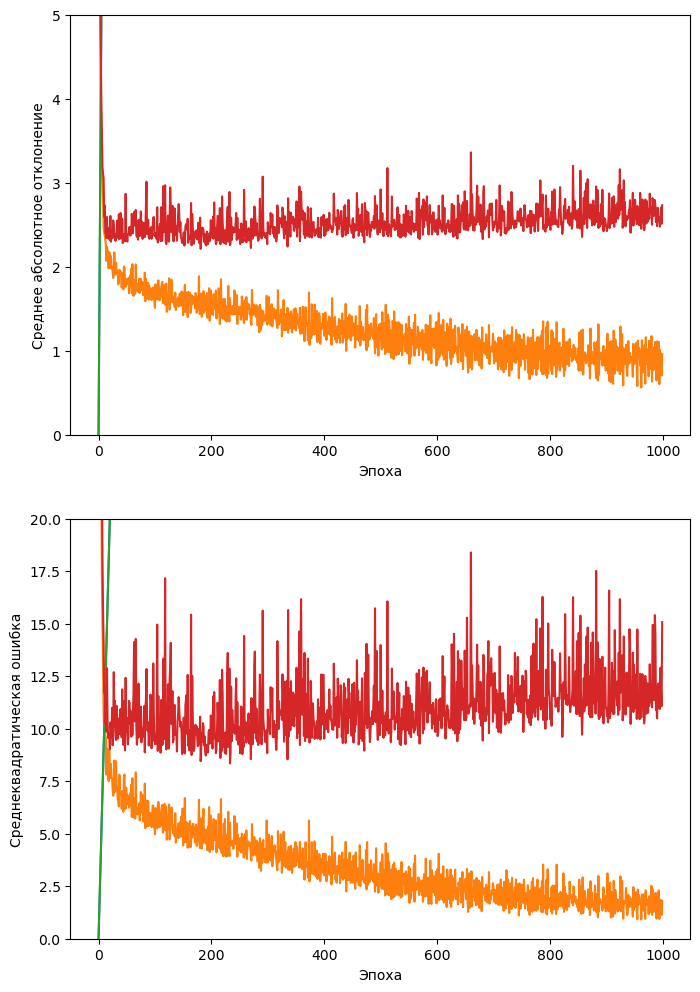

In [38]:
# Функция визуализации процесса обучения 
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднее абсолютное отклонение')
    #plt.plot (hist['epoch']), hist['mae'], label= 'Ошибка при обучении')
    plt.plot (hist['epoch'])
    plt.plot (hist['mae'])
    plt.plot(label='Ошибка при обучении')
    # plt.plot (hist['epoch'], hist['val_mae'], label = 'Ошибка при проверке')
    plt.plot (hist['epoch'])
    plt.plot (hist['val_mae'])
    plt.plot(label='Ошибка при проверке')
    plt.ylim([0,5])
    #plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднеквадратическая ошибка')
    #plt.plot(hist['epoch'], hist['mse'], label='Ошибка при обучении')
    plt.plot(hist['epoch'])
    plt.plot(hist['mse'])
    plt.plot(label='Ошибка при обучении')
    #plt.plot(hist['epoch'], hist['val_mse'], label = 'Ошибка при проверке')
    plt.plot(hist['epoch'])
    plt.plot(hist['val_mse'])
    plt.plot(label='Ошибка при проверке')
    plt.ylim([0,20])
    #plt.legend()
    plt.show()

plot_history(history)


....................................................................................................
................................................................................

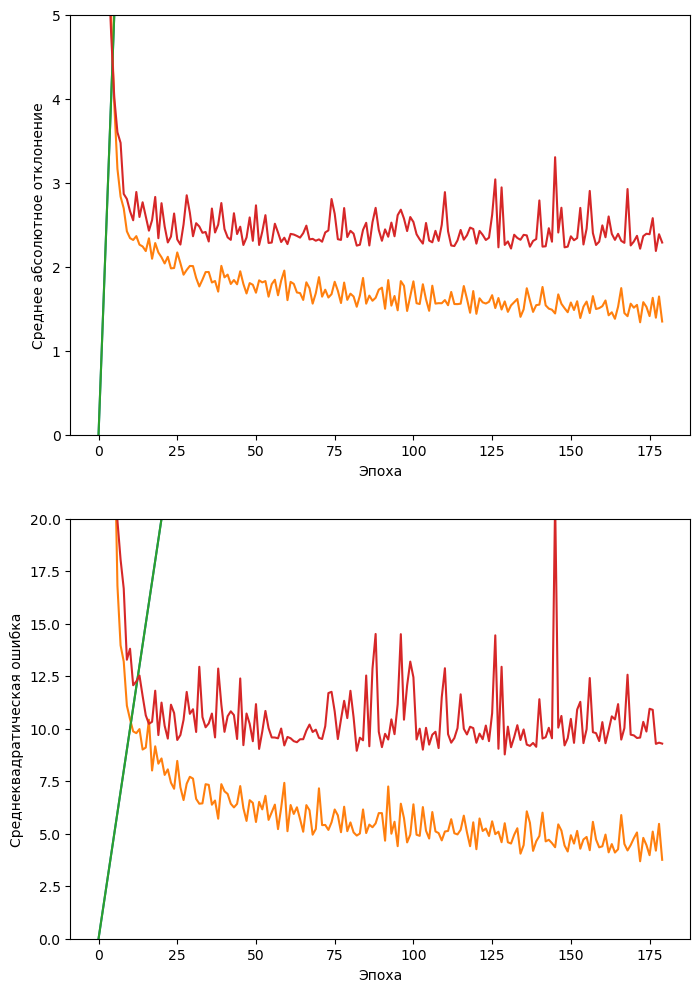

In [39]:
model = build_model()

# Параметр patience определяет количество эпох, которые можно пропустить без улучшений
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
# На следующем шаге обученная модель проверяется на наборе данных для проверки:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Среднее абсолютное отклонение на проверочных данных: {:5.2f} галлон на милю".format(mae))
print("Потери: {:5.2f}".format(loss))
print("Средняя квадратическая ошибка на проверочных данных: {:5.2f}".format(mse))

Среднее абсолютное отклонение на проверочных данных:  1.87 галлон на милю
Потери:  6.12
Средняя квадратическая ошибка на проверочных данных:  6.12


3/3 [==============================] - 0s 4ms/step


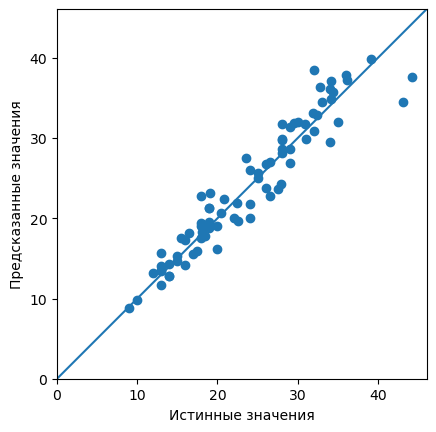

In [41]:
# Выполним предсказания показателей расхода топлива, используя набор наши проверочные данные:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

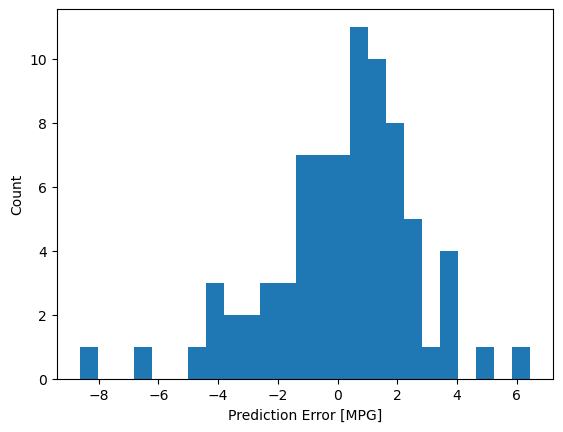

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [43]:
print(train_labels)


146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: Расход топлива, Length: 314, dtype: float64


In [44]:
train_dataset.tail()

,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,США,Европа,Япония
281,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0
182,4,107.0,86.0,2464.0,15.5,76,0.0,1.0,0.0


In [45]:
#Тут я попробовал обучить модель через К блоки.
import numpy as np
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)
k = 4
num_val_samples = len(normed_train_data) // k
num_epochs = 100
all_scores = []
for i in range(k): 
    print('processing fold #', i) 
    # Подготовка проверочных данных: данных из блока k
    val_data=normed_train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = normed_train_data[i * num_val_samples: (i + 1)
             * num_val_samples] 
    # Подготовка обучающих данных
    partial_train_data = np.concatenate( 
        [normed_train_data[:i * num_val_samples], 
        normed_train_data[(i + 1) * num_val_samples:]],
        axis=0) 
    partial_train_targets = np.concatenate( 
          [train_labels[:i * num_val_samples], 
          train_labels[(i + 1) * num_val_samples:]], 
          axis=0) 
    # Конструирование модели Keras (уже скомпилированной)
    Dense3_model = build_model() 
    # Обучение модели (в режиме «без вывода сообщений»  verbose=0)
    Dense3_model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=0, validation_data=(val_data, val_targets),
            callbacks=[early_stop]) 
    #  Оценка модели по проверочным данным
    val_mae = Dense3_model.evaluate(val_data, val_targets, verbose=0)

    all_scores.append(val_mae)






processing fold # 0


processing fold # 1
processing fold # 2
processing fold # 3


In [46]:
all_scores


[[516.762939453125, 21.851669311523438, 516.762939453125],
 [757.111328125, 26.00301742553711, 757.111328125],
 [562.7909545898438, 22.42000961303711, 562.7909545898438],
 [665.7675170898438, 24.945568084716797, 665.7675170898438]]

In [47]:
np.mean(all_scores)

425.00714524586994

In [48]:
loss, mae, mse = Dense3_model.evaluate(normed_test_data, test_labels, verbose=0)

print("Среднее абсолютное отклонение на проверочных данных: {:5.2f} галлон на милю".format(mae))
print("Средняя квадратическая ошибка на проверочных данных: {:5.2f}".format(mse))
print(round(mae,2))

Среднее абсолютное отклонение на проверочных данных:  2.55 галлон на милю
Средняя квадратическая ошибка на проверочных данных:  9.67
2.55


3/3 [==============================] - 0s 3ms/step


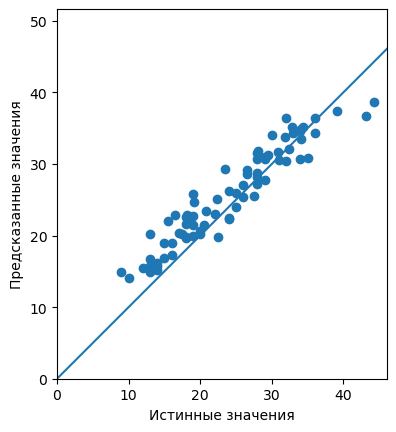

In [49]:
test_predictions = Dense3_model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

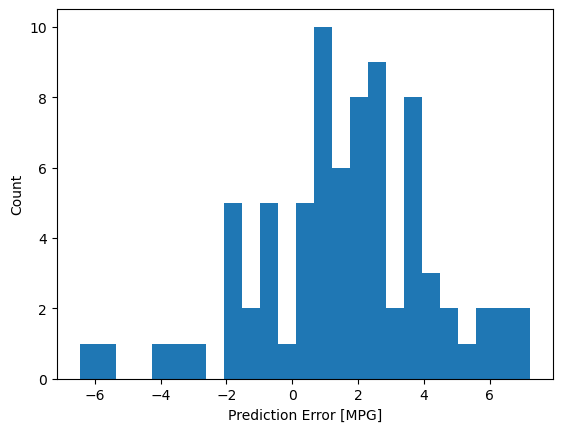

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [51]:
Dense3_model.save('Dense3_model.h5')
baza_model = keras.models.load_model('model_baza.h5')
baza_model2 = keras.models.load_model('model_baza2KBloki.h5')
Dense3_model = keras.models.load_model('Dense3_model.h5')
loss, mae, mse = Dense3_model.evaluate(normed_test_data, test_labels, verbose=0)

print("Среднее абсолютное отклонение на проверочных данных: {:5.2f} галлон на милю".format(mae))
print("Средняя квадратическая ошибка на проверочных данных: {:5.2f}".format(mse))


Среднее абсолютное отклонение на проверочных данных:  2.55 галлон на милю
Средняя квадратическая ошибка на проверочных данных:  9.67
